# Classifiers - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
def scale_data(x, standardScaler=True, minMaxScaler=True):
    
    if standardScaler:
        # Scale with standard scaler
        sscaler = StandardScaler()
        sscaler.fit(x)
        x = sscaler.transform(x)

    if minMaxScaler:
        # Scale with MinMax to range [0,1]
        mmscaler = MinMaxScaler((0,1))
        mmscaler.fit(x)
        x = mmscaler.transform(x)
    
    return x

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
phase_all_train = scale_data(phase_all_train)

# load all phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
phase_all_valid = scale_data(phase_all_valid)

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 256
epochs = 500
encoding_dim = 60
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [16]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [17]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

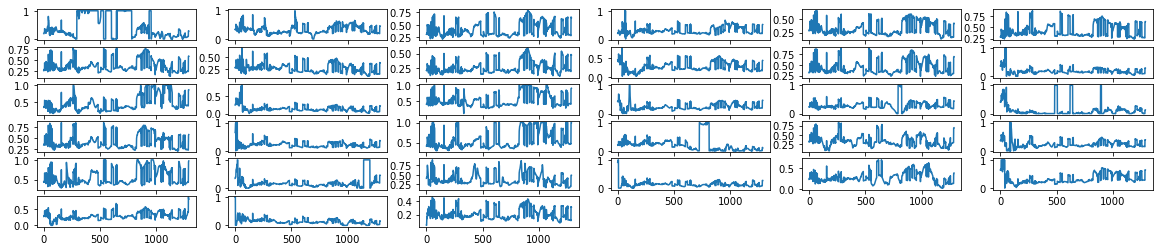

<Figure size 432x288 with 0 Axes>

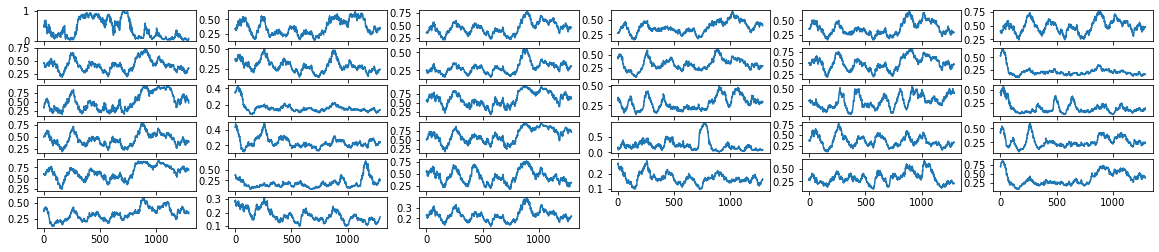

In [18]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

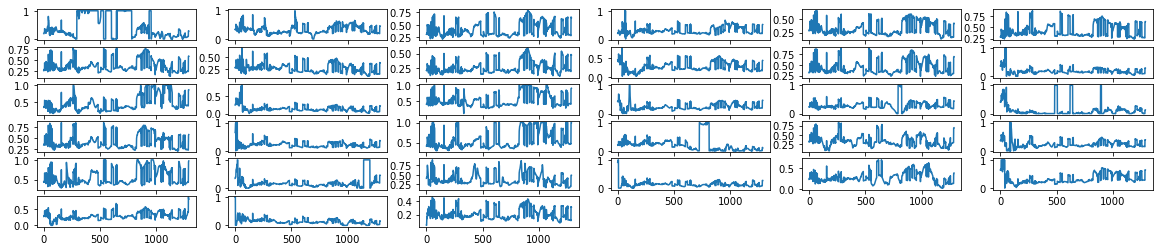

<Figure size 432x288 with 0 Axes>

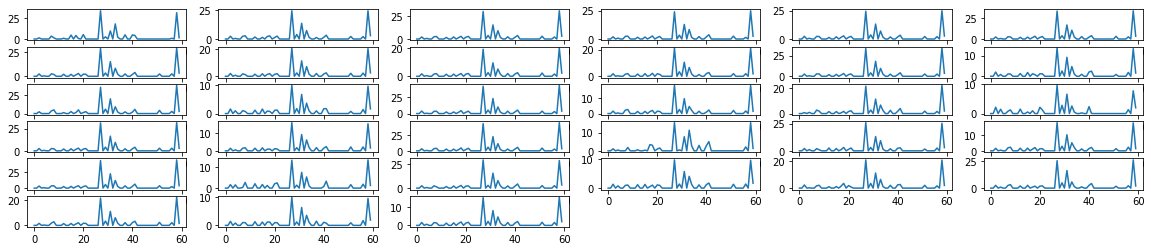

In [19]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [20]:
np.sum(np.mean(data2, axis=0) < 0.1)

38

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [22]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [23]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

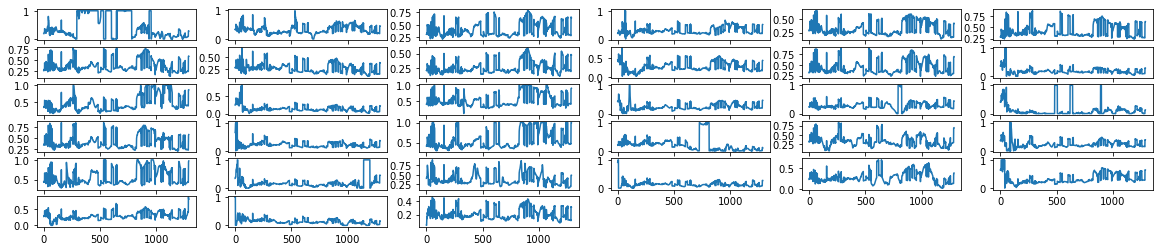

<Figure size 432x288 with 0 Axes>

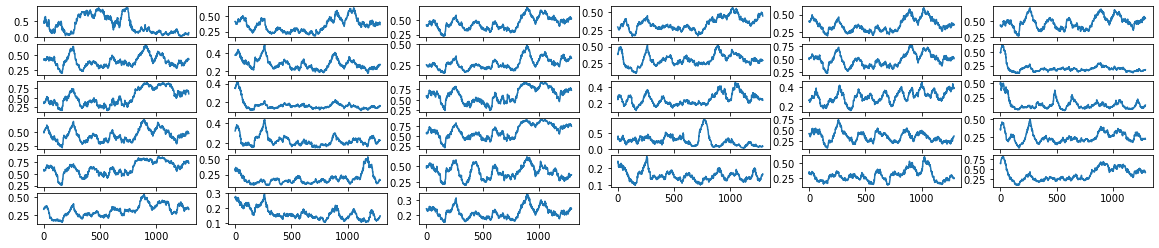

In [24]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

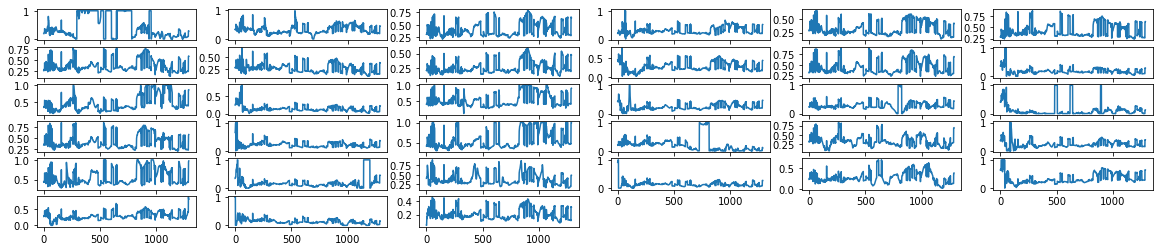

<Figure size 432x288 with 0 Axes>

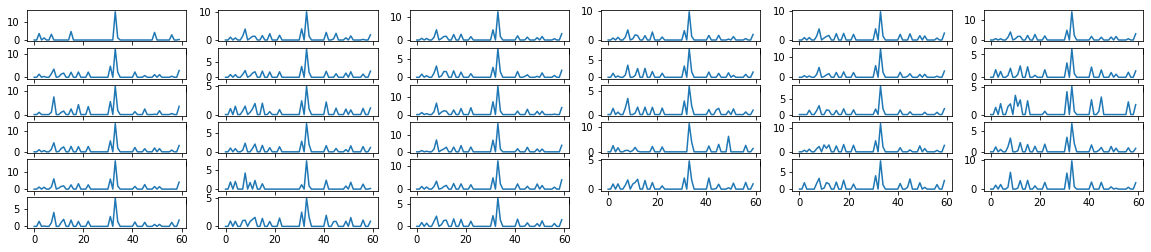

In [25]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [26]:
print(np.sum(np.mean(data2, axis=0) < 0.1))
np.mean(data2, axis=0)

40


array([0.        , 0.        , 1.0101546 , 0.        , 0.8864955 ,
       0.        , 0.        , 1.251024  , 3.2588096 , 0.        ,
       0.6364311 , 1.3102701 , 1.7302393 , 0.        , 0.        ,
       1.9010421 , 0.        , 0.        , 1.8375571 , 0.        ,
       0.        , 0.        , 1.6667386 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.506131  , 0.        , 9.569667  , 1.5897361 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.8014715 , 0.        , 0.        , 0.14418063,
       1.460188  , 0.        , 0.        , 0.        , 1.1747293 ,
       0.        , 1.4010332 , 0.        , 0.        , 0.        ,
       0.        , 0.8343932 , 0.        , 0.        , 2.1208937 ],
      dtype=float32)

Store the encoded representations in the data dictionary:

In [27]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [28]:
def deep_ae(x, enc_layers=[512,256], encoding_dim=64, dec_layers=[256,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.25, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [29]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

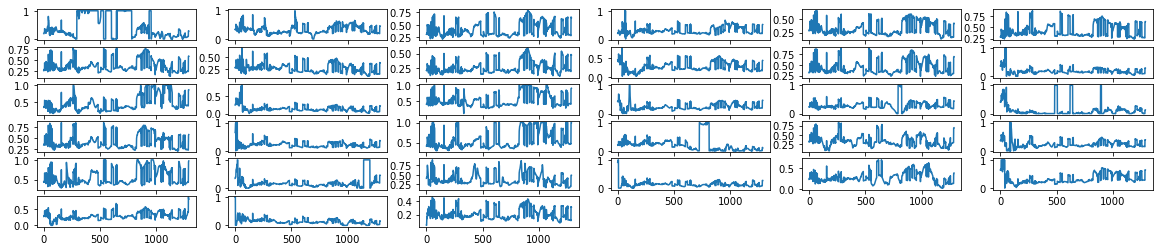

<Figure size 432x288 with 0 Axes>

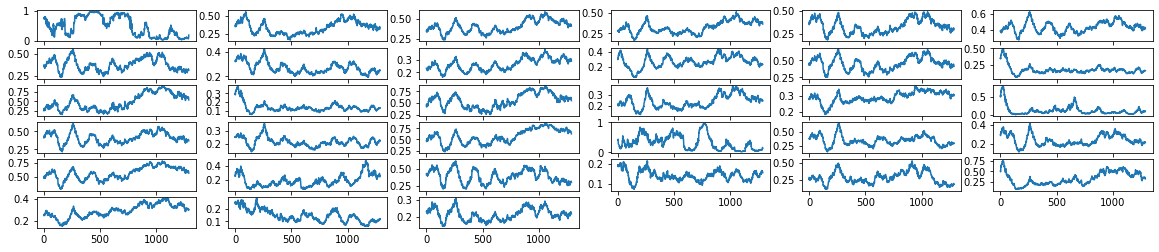

In [30]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

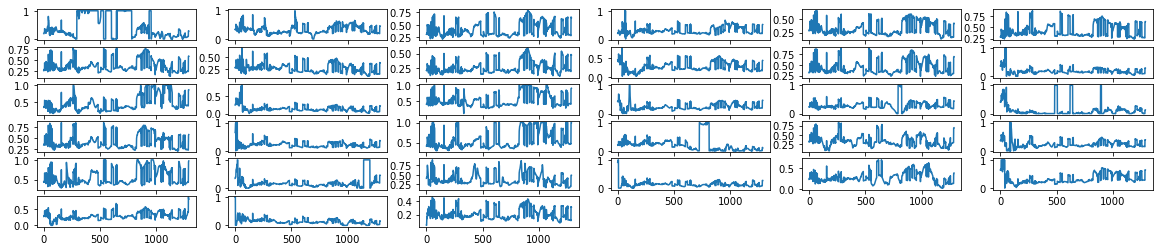

<Figure size 432x288 with 0 Axes>

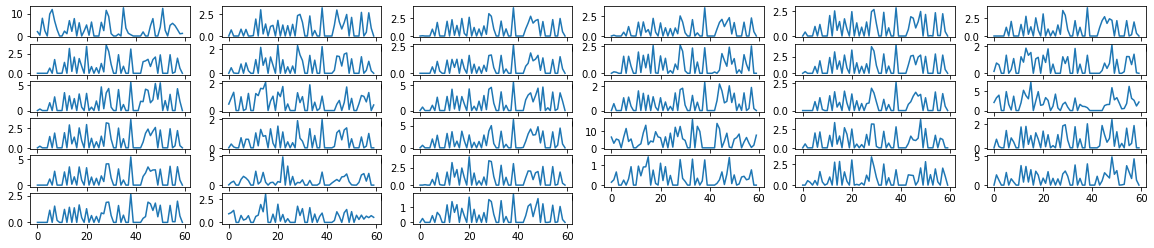

In [31]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [32]:
print(np.sum(np.mean(data2, axis=0) < 0.1))
np.mean(data2, axis=0)

14


array([0.33811635, 0.61846167, 0.5467646 , 0.21248882, 0.0101117 ,
       1.4735086 , 0.5786814 , 1.3698927 , 0.46316174, 0.        ,
       0.00643864, 1.773905  , 0.3571147 , 2.5346088 , 0.9799368 ,
       1.9590267 , 0.08197742, 1.7997074 , 1.2110205 , 0.18029106,
       2.2528462 , 0.19151519, 1.503466  , 0.        , 0.9487414 ,
       0.08377051, 1.5182593 , 0.3134417 , 2.6128647 , 2.4186418 ,
       1.0351762 , 0.        , 0.        , 2.3293874 , 0.        ,
       1.2557755 , 0.3866183 , 0.15297167, 2.884005  , 0.        ,
       0.        , 0.        , 0.0709241 , 1.1129242 , 2.061662  ,
       1.8367083 , 1.2411195 , 1.8388369 , 2.4094732 , 0.27455282,
       2.0728052 , 0.3632849 , 0.37406394, 0.07927823, 2.032999  ,
       0.5213288 , 0.6070323 , 1.9501063 , 0.6090379 , 0.2132457 ],
      dtype=float32)

Store the encoded representations in the data dictionary:

In [33]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [34]:
def get_ident_data_from_dict(idents, data_dict, should_scale_data=True):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    if should_scale_data:
        # Scale each data before returning
        phase = scale_data(phase)
        breathing = scale_data(breathing)
        heartbeat = scale_data(heartbeat)
        combined = scale_data(combined)
        undercomplete_encoded = scale_data(undercomplete_encoded)
        sparse_encoded = scale_data(sparse_encoded)
        deep_encoded = scale_data(deep_encoded)
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

In [35]:
# '62i9y''2gu87''iz2ps'

y_train, phase_train, br_train, hb_train, cmb_train, undercomplete_encoded_train, \
sparse_encoded_train, deep_encoded_train = get_ident_data_from_dict(['62i9y','2gu87'], data_dict)

phase_train2, y_train2, _, _, _ = get_data_from_idents_br_hb(path, ['62i9y','2gu87'], seconds)

phase_train2 = scale_data(phase_train2)

(phase_train == phase_train2).all()

True

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [36]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict, should_scale_data)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict, should_scale_data)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict, should_scale_data)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']
        
        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for index in range(num_loops_to_average_over):
                clear_session_and_set_seeds()
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [37]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [38]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [39]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:15.551509
iteration: 3 of 23 ; time elapsed: 0:00:31.602130
iteration: 4 of 23 ; time elapsed: 0:00:49.012344
iteration: 5 of 23 ; time elapsed: 0:01:05.481362
iteration: 6 of 23 ; time elapsed: 0:01:20.909689
iteration: 7 of 23 ; time elapsed: 0:01:36.814441
iteration: 8 of 23 ; time elapsed: 0:01:52.343387
iteration: 9 of 23 ; time elapsed: 0:02:07.808437
iteration: 10 of 23 ; time elapsed: 0:02:23.295970
iteration: 11 of 23 ; time elapsed: 0:02:39.326149
iteration: 12 of 23 ; time elapsed: 0:02:54.629131
iteration: 13 of 23 ; time elapsed: 0:03:09.657143
iteration: 14 of 23 ; time elapsed: 0:03:25.292967
iteration: 15 of 23 ; time elapsed: 0:03:40.699050
iteration: 16 of 23 ; time elapsed: 0:03:56.075595
iteration: 17 of 23 ; time elapsed: 0:04:11.471877
iteration: 18 of 23 ; time elapsed: 0:04:27.127289
iteration: 19 of 23 ; time elapsed: 0:04:42.275523
iteration: 20 of 23 ; time elapsed: 0:04:58.527

In [40]:
accuracies['simple_dense'] = accs

In [41]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.458333,0.375000,0.416667,0.416667,0.666667,0.666667,0.583333,62i9y
1,0.558824,0.705882,0.205882,0.588235,0.470588,0.470588,0.500000,2gu87
2,0.527778,0.805556,0.361111,0.750000,0.583333,0.527778,0.472222,iz2ps
3,0.647059,0.823529,0.441176,0.823529,0.470588,0.588235,0.647059,1mpau
4,0.633333,0.500000,0.400000,0.566667,0.500000,0.466667,0.433333,7dwjy
5,0.625000,0.843750,0.500000,0.875000,0.500000,0.781250,0.687500,7swyk
6,0.562500,0.593750,0.500000,0.687500,0.562500,0.593750,0.531250,94mnx
7,0.466667,0.700000,0.466667,0.666667,0.533333,0.500000,0.566667,bd47a
8,0.466667,0.800000,0.533333,0.833333,0.466667,0.500000,0.400000,c24ur
9,0.633333,0.833333,0.633333,0.866667,0.500000,0.666667,0.600000,ctsax


In [42]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.400000   0.375000   0.205882        0.416667       0.466667  0.382353  0.382353
max     0.718750   0.852941   0.718750        0.875000       0.666667  0.888889  0.687500
mean    0.538422   0.677209   0.484351        0.685259       0.523362  0.563985  0.534996
median  0.531250   0.700000   0.470588        0.687500       0.500000  0.527778  0.531250


#### LSTM-based classifier  
based on the original author's code

In [43]:
params_phase = {
    'kernel_size': 4,
    'filters': 3,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [44]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 2,
    'strides': 1,
    'pool_size': 1,
    'dropout': 0.09,
    'lstm_output_size': 4,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [45]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [46]:
accs = helper_loop(LSTM_train, idents, n=5)

iteration: 1 of 5 ; time elapsed: 0:00:00
iteration: 2 of 5 ; time elapsed: 0:03:58.528211
iteration: 3 of 5 ; time elapsed: 0:07:59.642452
iteration: 4 of 5 ; time elapsed: 0:12:14.419441
iteration: 5 of 5 ; time elapsed: 0:16:26.761009
Completed! Time elapsed: 0:20:31.420427


In [47]:
accuracies['LSTM'] = accs

In [48]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.541667,0.5,0.5,0.5,0.5,0.5,0.5,62i9y
1,0.470588,0.5,0.5,0.5,0.5,0.5,0.5,2gu87
2,0.444444,0.5,0.5,0.5,0.5,0.5,0.5,iz2ps
3,0.500000,0.5,0.5,0.5,0.5,0.5,0.5,1mpau
4,0.466667,0.5,0.5,0.5,0.5,0.5,0.5,7dwjy


In [49]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete  sparse  deep
min     0.444444        0.5        0.5             0.5            0.5     0.5   0.5
max     0.541667        0.5        0.5             0.5            0.5     0.5   0.5
mean    0.484673        0.5        0.5             0.5            0.5     0.5   0.5
median  0.470588        0.5        0.5             0.5            0.5     0.5   0.5


#### kNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [51]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [52]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.114722
iteration: 3 of 23 ; time elapsed: 0:00:00.215451
iteration: 4 of 23 ; time elapsed: 0:00:00.312194
iteration: 5 of 23 ; time elapsed: 0:00:00.413459
iteration: 6 of 23 ; time elapsed: 0:00:00.510201
iteration: 7 of 23 ; time elapsed: 0:00:00.608479
iteration: 8 of 23 ; time elapsed: 0:00:00.705220
iteration: 9 of 23 ; time elapsed: 0:00:00.803956
iteration: 10 of 23 ; time elapsed: 0:00:00.912636
iteration: 11 of 23 ; time elapsed: 0:00:01.016067
iteration: 12 of 23 ; time elapsed: 0:00:01.112812
iteration: 13 of 23 ; time elapsed: 0:00:01.209582
iteration: 14 of 23 ; time elapsed: 0:00:01.307895
iteration: 15 of 23 ; time elapsed: 0:00:01.401676
iteration: 16 of 23 ; time elapsed: 0:00:01.498417
iteration: 17 of 23 ; time elapsed: 0:00:01.597582
iteration: 18 of 23 ; time elapsed: 0:00:01.693357
iteration: 19 of 23 ; time elapsed: 0:00:01.789101
iteration: 20 of 23 ; time elapsed: 0:00:01.894

In [53]:
accuracies['kNN'] = accs

In [54]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.458333,0.333333,0.416667,0.583333,0.416667,0.541667,62i9y
1,0.588235,0.647059,0.352941,0.676471,0.588235,0.647059,0.558824,2gu87
2,0.638889,0.638889,0.472222,0.750000,0.416667,0.750000,0.638889,iz2ps
3,0.676471,0.676471,0.441176,0.617647,0.588235,0.588235,0.500000,1mpau
4,0.700000,0.600000,0.400000,0.600000,0.633333,0.633333,0.633333,7dwjy
5,0.812500,0.812500,0.437500,0.781250,0.687500,0.718750,0.531250,7swyk
6,0.687500,0.531250,0.562500,0.531250,0.531250,0.656250,0.593750,94mnx
7,0.600000,0.633333,0.600000,0.700000,0.600000,0.766667,0.466667,bd47a
8,0.700000,0.700000,0.533333,0.700000,0.500000,0.666667,0.733333,c24ur
9,0.666667,0.833333,0.466667,0.733333,0.566667,0.533333,0.500000,ctsax


In [55]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.437500   0.458333   0.277778        0.416667       0.416667  0.416667  0.312500
max     0.812500   0.833333   0.687500        0.781250       0.735294  0.833333  0.733333
mean    0.637376   0.653163   0.477625        0.638079       0.581545  0.624277  0.541507
median  0.638889   0.647059   0.468750        0.676471       0.583333  0.633333  0.531250


####  SVC

In [56]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [57]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.868955
iteration: 3 of 23 ; time elapsed: 0:00:01.714709
iteration: 4 of 23 ; time elapsed: 0:00:02.554842
iteration: 5 of 23 ; time elapsed: 0:00:03.404568
iteration: 6 of 23 ; time elapsed: 0:00:04.276256
iteration: 7 of 23 ; time elapsed: 0:00:05.136060
iteration: 8 of 23 ; time elapsed: 0:00:05.989675
iteration: 9 of 23 ; time elapsed: 0:00:06.836917
iteration: 10 of 23 ; time elapsed: 0:00:07.693661
iteration: 11 of 23 ; time elapsed: 0:00:08.545292
iteration: 12 of 23 ; time elapsed: 0:00:09.395819
iteration: 13 of 23 ; time elapsed: 0:00:10.245568
iteration: 14 of 23 ; time elapsed: 0:00:11.090887
iteration: 15 of 23 ; time elapsed: 0:00:11.936488
iteration: 16 of 23 ; time elapsed: 0:00:12.778345
iteration: 17 of 23 ; time elapsed: 0:00:13.618570
iteration: 18 of 23 ; time elapsed: 0:00:14.467290
iteration: 19 of 23 ; time elapsed: 0:00:15.310008
iteration: 20 of 23 ; time elapsed: 0:00:16.154

In [59]:
accuracies['SVC'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.500000,0.500000,0.500000,0.583333,0.625000,0.583333,62i9y
1,0.676471,0.705882,0.352941,0.735294,0.705882,0.705882,0.558824,2gu87
2,0.777778,0.666667,0.333333,0.750000,0.666667,0.722222,0.472222,iz2ps
3,0.529412,0.764706,0.588235,0.764706,0.529412,0.529412,0.647059,1mpau
4,0.666667,0.533333,0.466667,0.566667,0.566667,0.566667,0.533333,7dwjy
5,0.468750,0.656250,0.656250,0.781250,0.500000,0.718750,0.718750,7swyk
6,0.656250,0.625000,0.656250,0.625000,0.531250,0.593750,0.562500,94mnx
7,0.633333,0.633333,0.633333,0.566667,0.566667,0.600000,0.500000,bd47a
8,0.733333,0.733333,0.566667,0.766667,0.500000,0.533333,0.466667,c24ur
9,0.633333,0.866667,0.566667,0.700000,0.533333,0.600000,0.666667,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.416667   0.468750   0.333333        0.500000       0.411765  0.400000  0.466667
max     0.777778   0.866667   0.733333        0.812500       0.705882  0.722222  0.718750
mean    0.600197   0.646355   0.518363        0.650622       0.543466  0.574757  0.568919
median  0.633333   0.656250   0.500000        0.647059       0.531250  0.588235  0.558824


#### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [63]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:05.306535
iteration: 3 of 23 ; time elapsed: 0:00:10.497094
iteration: 4 of 23 ; time elapsed: 0:00:15.638798
iteration: 5 of 23 ; time elapsed: 0:00:20.776039
iteration: 6 of 23 ; time elapsed: 0:00:25.970707
iteration: 7 of 23 ; time elapsed: 0:00:31.196083
iteration: 8 of 23 ; time elapsed: 0:00:36.339979
iteration: 9 of 23 ; time elapsed: 0:00:41.512165
iteration: 10 of 23 ; time elapsed: 0:00:46.762961
iteration: 11 of 23 ; time elapsed: 0:00:52.009624
iteration: 12 of 23 ; time elapsed: 0:00:57.151198
iteration: 13 of 23 ; time elapsed: 0:01:02.295157
iteration: 14 of 23 ; time elapsed: 0:01:07.389562
iteration: 15 of 23 ; time elapsed: 0:01:12.548776
iteration: 16 of 23 ; time elapsed: 0:01:17.713015
iteration: 17 of 23 ; time elapsed: 0:01:22.865958
iteration: 18 of 23 ; time elapsed: 0:01:28.010739
iteration: 19 of 23 ; time elapsed: 0:01:33.255394
iteration: 20 of 23 ; time elapsed: 0:01:38.532

In [65]:
accuracies['random_forest'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.708333,0.625000,0.500000,0.500000,0.708333,0.708333,0.708333,62i9y
1,0.588235,0.735294,0.558824,0.705882,0.647059,0.676471,0.617647,2gu87
2,0.722222,0.888889,0.500000,0.888889,0.805556,0.888889,0.805556,iz2ps
3,0.705882,0.647059,0.558824,0.735294,0.558824,0.470588,0.588235,1mpau
4,0.600000,0.600000,0.566667,0.600000,0.433333,0.600000,0.666667,7dwjy
5,0.750000,0.812500,0.437500,0.812500,0.750000,0.781250,0.812500,7swyk
6,0.562500,0.625000,0.562500,0.593750,0.500000,0.500000,0.500000,94mnx
7,0.600000,0.600000,0.533333,0.600000,0.500000,0.566667,0.533333,bd47a
8,0.733333,0.866667,0.533333,0.933333,0.600000,0.500000,0.533333,c24ur
9,0.700000,0.900000,0.633333,0.866667,0.633333,0.766667,0.700000,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.500000   0.437500   0.406250        0.468750       0.433333  0.466667  0.441176
max     0.875000   0.900000   0.656250        0.933333       0.805556  0.888889  0.812500
mean    0.669297   0.695180   0.507577        0.686868       0.614392  0.615502  0.607237
median  0.676471   0.676471   0.527778        0.687500       0.633333  0.625000  0.588235


#### Naive Bayesian

In [68]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [69]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [70]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.082805
iteration: 3 of 23 ; time elapsed: 0:00:00.166581
iteration: 4 of 23 ; time elapsed: 0:00:00.245371
iteration: 5 of 23 ; time elapsed: 0:00:00.322167
iteration: 6 of 23 ; time elapsed: 0:00:00.402949
iteration: 7 of 23 ; time elapsed: 0:00:00.483272
iteration: 8 of 23 ; time elapsed: 0:00:00.564089
iteration: 9 of 23 ; time elapsed: 0:00:00.641909
iteration: 10 of 23 ; time elapsed: 0:00:00.723691
iteration: 11 of 23 ; time elapsed: 0:00:00.800488
iteration: 12 of 23 ; time elapsed: 0:00:00.882267
iteration: 13 of 23 ; time elapsed: 0:00:00.963296
iteration: 14 of 23 ; time elapsed: 0:00:01.040602
iteration: 15 of 23 ; time elapsed: 0:00:01.122383
iteration: 16 of 23 ; time elapsed: 0:00:01.209628
iteration: 17 of 23 ; time elapsed: 0:00:01.293911
iteration: 18 of 23 ; time elapsed: 0:00:01.376229
iteration: 19 of 23 ; time elapsed: 0:00:01.454986
iteration: 20 of 23 ; time elapsed: 0:00:01.532

In [71]:
accuracies['naive_bayesian'] = accs

In [72]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.625000,0.458333,0.375000,0.458333,0.541667,0.541667,0.458333,62i9y
1,0.382353,0.676471,0.294118,0.705882,0.529412,0.470588,0.382353,2gu87
2,0.305556,0.750000,0.388889,0.750000,0.361111,0.500000,0.388889,iz2ps
3,0.500000,0.823529,0.441176,0.823529,0.558824,0.500000,0.558824,1mpau
4,0.433333,0.466667,0.466667,0.466667,0.400000,0.500000,0.433333,7dwjy
5,0.687500,0.875000,0.406250,0.875000,0.562500,0.656250,0.593750,7swyk
6,0.500000,0.687500,0.531250,0.687500,0.468750,0.562500,0.375000,94mnx
7,0.400000,0.666667,0.466667,0.700000,0.500000,0.500000,0.466667,bd47a
8,0.466667,0.800000,0.666667,0.866667,0.400000,0.500000,0.533333,c24ur
9,0.666667,0.933333,0.566667,0.933333,0.500000,0.566667,0.500000,ctsax


In [73]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.294118   0.406250   0.294118        0.343750       0.294118  0.264706  0.323529
max     0.735294   0.933333   0.666667        0.933333       0.676471  0.705882  0.687500
mean    0.509914   0.693413   0.476543        0.691098       0.495141  0.533637  0.496332
median  0.500000   0.718750   0.470588        0.705882       0.500000  0.500000  0.500000


#### XGBoost

In [74]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [75]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [76]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:02.457809
iteration: 3 of 23 ; time elapsed: 0:00:04.683697
iteration: 4 of 23 ; time elapsed: 0:00:06.909632
iteration: 5 of 23 ; time elapsed: 0:00:09.156074
iteration: 6 of 23 ; time elapsed: 0:00:11.380219
iteration: 7 of 23 ; time elapsed: 0:00:13.621376
iteration: 8 of 23 ; time elapsed: 0:00:15.834035
iteration: 9 of 23 ; time elapsed: 0:00:18.115004
iteration: 10 of 23 ; time elapsed: 0:00:20.483541
iteration: 11 of 23 ; time elapsed: 0:00:23.024743
iteration: 12 of 23 ; time elapsed: 0:00:25.380314
iteration: 13 of 23 ; time elapsed: 0:00:27.700975
iteration: 14 of 23 ; time elapsed: 0:00:30.021889
iteration: 15 of 23 ; time elapsed: 0:00:32.394862
iteration: 16 of 23 ; time elapsed: 0:00:34.698001
iteration: 17 of 23 ; time elapsed: 0:00:36.965716
iteration: 18 of 23 ; time elapsed: 0:00:39.274032
iteration: 19 of 23 ; time elapsed: 0:00:41.566894
iteration: 20 of 23 ; time elapsed: 0:00:43.868

In [77]:
accuracies['XGBoost'] = accs

In [78]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.625000,0.625000,0.500000,0.583333,0.625000,0.625000,0.583333,62i9y
1,0.617647,0.794118,0.500000,0.705882,0.470588,0.617647,0.588235,2gu87
2,0.666667,0.861111,0.527778,0.861111,0.805556,0.722222,0.750000,iz2ps
3,0.735294,0.617647,0.588235,0.794118,0.647059,0.705882,0.558824,1mpau
4,0.600000,0.633333,0.566667,0.633333,0.500000,0.466667,0.666667,7dwjy
5,0.718750,0.750000,0.375000,0.750000,0.656250,0.750000,0.781250,7swyk
6,0.625000,0.656250,0.437500,0.593750,0.531250,0.468750,0.593750,94mnx
7,0.633333,0.566667,0.500000,0.433333,0.666667,0.566667,0.500000,bd47a
8,0.566667,0.900000,0.533333,0.866667,0.466667,0.633333,0.466667,c24ur
9,0.700000,0.766667,0.666667,0.800000,0.566667,0.666667,0.566667,ctsax


In [79]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.466667   0.500000   0.343750        0.343750       0.437500  0.466667  0.433333
max     0.735294   0.900000   0.687500        0.866667       0.805556  0.764706  0.781250
mean    0.625753   0.685035   0.501948        0.685170       0.574629  0.625535  0.582941
median  0.625000   0.676471   0.500000        0.700000       0.566667  0.647059  0.566667


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [80]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.400000   0.375000   0.205882        0.416667       0.466667  0.382353  0.382353
max     0.718750   0.852941   0.718750        0.875000       0.666667  0.888889  0.687500
mean    0.538422   0.677209   0.484351        0.685259       0.523362  0.563985  0.534996
median  0.531250   0.700000   0.470588        0.687500       0.500000  0.527778  0.531250


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete  sparse  deep
min     0.444444        0.5        0.5             0.5            0.5     0.5   0.5
max     0.541667        0.5        0.5             0.5            0.5     0.5   0.5
mean    0.484673        0.5        0.5             0.5            0.5     0.5   0.5
median  0.470588        0.5        0.5             0.5            0.5     0.5   0.5


----------- kNN: -----------
           phase  breathing  

Print all accuracies in table form:

In [81]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.458333   0.375000   0.416667        0.416667       0.666667  0.666667  0.583333   62i9y
1   0.558824   0.705882   0.205882        0.588235       0.470588  0.470588  0.500000   2gu87
2   0.527778   0.805556   0.361111        0.750000       0.583333  0.527778  0.472222   iz2ps
3   0.647059   0.823529   0.441176        0.823529       0.470588  0.588235  0.647059   1mpau
4   0.633333   0.500000   0.400000        0.566667       0.500000  0.466667  0.433333   7dwjy
5   0.625000   0.843750   0.500000        0.875000       0.500000  0.781250  0.687500   7swyk
6   0.562500   0.593750   0.500000        0.687500       0.562500  0.593750  0.531250   94mnx
7   0.466667   0.700000   0.466667        0.666667       0.533333  0.500000  0.566667   bd47a
8   0.466667   0.800000   0.533333        0.833333       0.466667  0.500000  0.400000   c24ur
9   0.633333   0.833333   0.633333        0.86